In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Final

/content/gdrive/MyDrive/Final


In [ ]:
%cd "/content/gdrive/MyDrive/Jedha/FS-2023/4 Projets/Final"

[Errno 2] No such file or directory: '/content/gdrive/MyDrive/Jedha/FS-2023/4 Projets/Final'
/content/gdrive/MyDrive/Final


In [ ]:
#rm -r /content/fruits360

In [ ]:
! ls

fruits360
ML_Transfert_learning.ipynb
models
TransferLearningModel_10epochs_lr0.0001_validation.h5
YOLO8_v1.ipynb


In [ ]:
! git clone https://github.com/971FLS/fruits360

fatal: destination path 'fruits360' already exists and is not an empty directory.


In [ ]:
from datetime import datetime
start = datetime.now()


In [ ]:
# Répertoire du dataset
url = "/content/gdrive/MyDrive/Final/fruits360/dataset"

In [ ]:
import tensorflow as tf
# import os
# ! pip install mlflow --quiet
# ! pip install boto3 --quiet
# import mlflow

In [ ]:

# # Set tracking URI to your Heroku application
# os.environ["APP_URI"] = "https://antiwaste-mlflow.herokuapp.com/"
# mlflow.set_tracking_uri(os.environ["APP_URI"])

# # set and get experiment's info
# EXPERIMENT_NAME="experiment_2"
# mlflow.set_experiment(EXPERIMENT_NAME)
# experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

In [ ]:
#os.environ["AWS_ACCESS_KEY_ID"] = "***********"
#os.environ["AWS_SECRET_ACCESS_KEY"] = "************"

In [ ]:
import pathlib
data_root = pathlib.Path(url)
print(data_root)

/content/gdrive/MyDrive/Final/fruits360/dataset


In [ ]:
for item in data_root.iterdir():
  print(item)

/content/gdrive/MyDrive/Final/fruits360/dataset/1.jpg
/content/gdrive/MyDrive/Final/fruits360/dataset/2.jpg
/content/gdrive/MyDrive/Final/fruits360/dataset/Test
/content/gdrive/MyDrive/Final/fruits360/dataset/Training
/content/gdrive/MyDrive/Final/fruits360/dataset/legumes-SANSplantravail.jpg
/content/gdrive/MyDrive/Final/fruits360/dataset/legumes-plantravail.jpg
/content/gdrive/MyDrive/Final/fruits360/dataset/102_100.jpg


In [ ]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(#rotation_range=90,
                                                                brightness_range=(0.5,1),
                                                                #shear_range=0.2,
                                                                #zoom_range=0.2,
                                                                channel_shift_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rescale=1./255,
                                                                validation_split=0.3)

In [ ]:
url_test = "/content/gdrive/MyDrive/Final/fruits360/dataset/Test"
url_train = "/content/gdrive/MyDrive/Final/fruits360/dataset/Training"

img_generator_flow_train = img_generator.flow_from_directory(
    directory=url_train,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    #subset="training"
    )

img_generator_flow_valid = img_generator.flow_from_directory(
    directory=url_test,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    #subset="validation"
    )

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

imgs, labels = next(iter(img_generator_flow_train))
for img, label in zip(imgs, labels):
  true_file_path = np.argmax(img_generator_flow_train.labels == tf.argmax(label))
  true_label_name = Path(img_generator_flow_train.filepaths[true_file_path]).parent.name
  print("Label :", true_label_name)
  #plt.imshow(img)
  plt.show()


Label : Apple Granny Smith
Label : Physalis
Label : Nut Pecan
Label : Cantaloupe 2
Label : Dates
Label : Ginger Root
Label : Maracuja
Label : Walnut
Label : Nut Forest
Label : Cantaloupe 2
Label : Mulberry
Label : Carambula
Label : Onion Red
Label : Pepino
Label : Tomato 4
Label : Grapefruit Pink
Label : Passion Fruit
Label : Grape Blue
Label : Mango Red
Label : Fig
Label : Banana Lady Finger
Label : Grapefruit Pink
Label : Physalis with Husk
Label : Pepper Red
Label : Apple Braeburn
Label : Pepper Red
Label : Apple Golden 2
Label : Pepper Green
Label : Physalis
Label : Banana Lady Finger
Label : Strawberry Wedge
Label : Lychee


# Importing the model

In [ ]:
base_model = tf.keras.applications.MobileNet(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
base_model.trainable = False

In [ ]:
# Adapting the model to the dataset

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(set(img_generator_flow_train.labels)), activation="softmax")
])

In [ ]:
# Let's create a learning rate schedule to decrease the learning rate as we train the model.
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)



In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_max_pooling2d (Globa  (None, 1024)             0         
 lMaxPooling2D)                                                  
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 131)               134275    
                                                                 
Total params: 3,363,139
Trainable params: 134,275
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
history = model.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, epochs=10)

Epoch 1/10
2116/2116 [==============================] - 636s 296ms/step - loss: 1.9684 - categorical_accuracy: 0.5933 - val_loss: 0.9231 - val_categorical_accuracy: 0.7648
Epoch 2/10
2116/2116 [==============================] - 664s 314ms/step - loss: 0.2385 - categorical_accuracy: 0.9411 - val_loss: 0.4983 - val_categorical_accuracy: 0.8661
Epoch 3/10
2116/2116 [==============================] - 606s 287ms/step - loss: 0.0867 - categorical_accuracy: 0.9830 - val_loss: 0.3565 - val_categorical_accuracy: 0.9027
Epoch 4/10
2116/2116 [==============================] - 611s 289ms/step - loss: 0.0413 - categorical_accuracy: 0.9938 - val_loss: 0.2926 - val_categorical_accuracy: 0.9214
Epoch 5/10
2116/2116 [==============================] - 608s 287ms/step - loss: 0.0237 - categorical_accuracy: 0.9970 - val_loss: 0.2508 - val_categorical_accuracy: 0.9311
Epoch 6/10
2116/2116 [==============================] - 616s 291ms/step - loss: 0.0144 - categorical_accuracy: 0.9986 - val_loss: 0.2132 - v

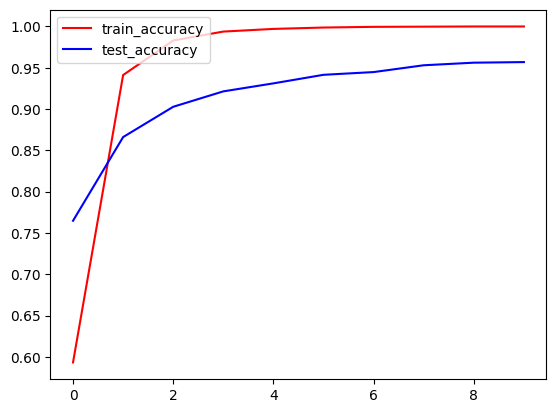

In [ ]:
# Visualise train / Valid Accuracy
plt.plot(model.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

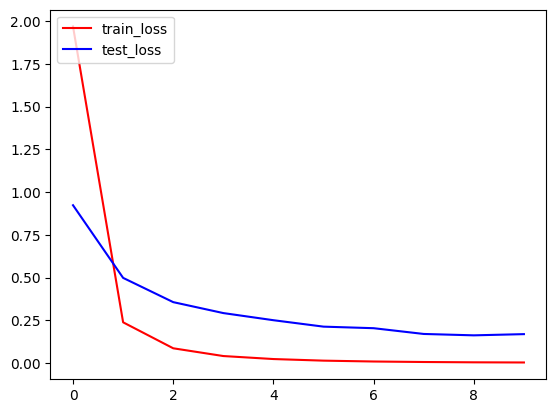

In [ ]:
# Visualise train / Valid Accuracy
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

In [ ]:
model.save("/content/gdrive/MyDrive/Final/models/TransferLearningModel_10epochs_lr0.0001_validation.h5")

In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/content/gdrive/MyDrive/Final/models/TransferLearningModel_10epochs_lr0.0001_validation.json", 'w'))


In [ ]:
end = datetime.now()
print(f"Le process a duré {end-start} minutes")

Le process a duré 1:45:39.156937 minutes


# Predict

In [ ]:
import numpy as np
from tensorflow import keras as keras
from keras.models import load_model
#model = load_model('/content/gdrive/MyDrive/Final/models/TransferLearningModel_10epochs_lr0.0001_validation.h5')
model = load_model('/content/gdrive/MyDrive/Jedha/FS-2023/4 Projets/Final/models/TransferLearningModel_10epochs_lr0.0001_validation.h5')

In [ ]:
model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import tensorflow as tf
def prepare_image(file):
    #img_path = '/content/gdrive/MyDrive/Final/fruits360/dataset/'
    img_path = '/content/gdrive/MyDrive/Jedha/FS-2023/4 Projets/Final/fruits360/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [ ]:
#img_predict = 'legumes-SANSplantravail.jpg'
# img_predict = '1.jpg'
img_predict = '2.jpg'

predictions = model.predict(prepare_image(img_predict))

1/1 [==============================] - 7s 7s/step


In [ ]:
# print(predictions.shape)
# type(predictions)

In [ ]:
pred = np.argmax(predictions)
print(pred)

116


In [ ]:
# Prédiction unique

#url = '/content/gdrive/MyDrive/Final/fruits360/dataset/Training'
url = '/content/gdrive/MyDrive/Jedha/FS-2023/4 Projets/Final/fruits360/dataset/Training'

import pathlib
data_root = pathlib.Path(url)
#print(data_root)
range = 0
for item in data_root.iterdir():
  if range == pred:
    print(str(item).rpartition('/')[-1])
  range += 1

Strawberry Wedge


In [ ]:
# HS
# Recherche dans liste de prédictions

url = '/content/gdrive/MyDrive/Final/fruits360/dataset/Training'

import pathlib
data_root = pathlib.Path(url)
#print(data_root)
range = 0
for item in data_root.iterdir():
  if range in predictions:
    print(str(item).rpartition('/')[-1])
  range += 1

FileNotFoundError: ignored